# JSSP

### Imports

In [136]:
import pandas as pd
import numpy as np
# import cvxpy as cp
import time
import dimod
import matplotlib.pyplot as plt
import gurobipy as gp
from matplotlib import rc


### Annealing simulation functions

In [137]:
def sendToDwave(qubo, shots=100):
    # Description: functions that solves a particular qubo problem

    # INPUT:
    # qubo: (matrix) representation of the xt*Q*x problem

    # OUTPUT:
    # sampleset: array of tuples of the form (solution, energy) of length "shots" containing posible (but not neccesarily feasible) solutions
    
    tic = time.perf_counter() # for time measuring
    sampleset = dimod.SimulatedAnnealingSampler().sample_qubo(qubo, num_reads=shots, beta_range=(0.01, 7))
    sampleset = sampleset.aggregate() # solo agrega soluciones DIFERENTES.
    sampleset = [(sample, energy) for sample, energy in zip(sampleset.record.sample, sampleset.record.energy)]
    toc = time.perf_counter() # for time measuring
    print(f"Simulating {shots} instances of annealing took: {(toc-tic)}s")
    # print("Sampleset sin filtrar: ", sampleset)
    return sampleset

def from_sample_to_int(sample):
    binary_list = sample[0].tolist()

    # Convert the binary list to a string and join the elements
    binary_string = ''.join(str(x) for x in binary_list)
    # Use the int() function with base 2 to convert the binary string to an integer
    result = int(binary_string, 2)
    return result

def count_elements(sample_list, total_spaces):
    frequency_dict = {}
    energy_dict = {}
    for item in sample_list:
        hashable_item = from_sample_to_int(item)
        if hashable_item in frequency_dict:
            frequency_dict[hashable_item] += 1
        else:
            energy_dict[hashable_item] = int(item[1])
            frequency_dict[hashable_item] = 1
    results_list = [bin(item)[2:] for item in frequency_dict]
    energies = list(energy_dict.values())
    frequencies = list(frequency_dict.values())

    new_results = []
    for result in results_list:
        if len(result) != total_spaces:
            ceros_string = '0' * int(total_spaces - len(result))
            result = ceros_string + result
        new_results.append(result)
    result = {'results': new_results, 'energies': energies, 'frequencies': frequencies}
    return result

def make_histogram(samples_dict):
    # Constructing an histogram to represent the solutions

    df = pd.DataFrame(samples_dict)
    print(df)

    # Sample data
    data = samples_dict

    # Extract the labels and the amounts into separate lists
    labels = data['results']
    amounts = data['frequencies']
    energies = data['energies']

    # Create a bar plot
    plt.bar(labels, amounts)

    for i, count in enumerate(amounts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    # Add labels and title to the plot
    plt.xlabel('Soluciones')
    plt.ylabel('Cantidades')
    plt.title('Soluciones y cantidad de veces que aparecen')

    # Show the plot
    plt.show()


In [138]:
def lowest_energy(sampleset):  # Finds the lowest energy solution
    
    # Description: given a full sampleset (tuples of the form (solution, energy) finds the lowest energy SAMPLE.
    # INPUTS:
    # Sampleset: a sampleset of the form list((solution, energy))

    # OUTPUTS:
    # best: a tuple of the form (solution, energy)

    if len(sampleset):
        energies = np.array([el[1] for el in sampleset])  # energias
        index = np.argmin(energies)  # indice de la de menor energia
        ret = sampleset[index]  # solucion de menor energia
        return ret

    else:
        return None

### Auxiliary functions

In [139]:
def get_index(v_list, value):
    index = 0
    for l in v_list:
        if l == value:
            return index
        index += 1
    return None


In [140]:
def get_subindexes(item):
    index_list = ""
    for sub_item in item:
        if index_list == "":
            index_list += str(sub_item)
        else:
            index_list += ","
            index_list += str(sub_item)
    return index_list

In [141]:
def get_variable_index(x, var_name):
    try:
        arr = x.index(var_name)
        return arr
    except:
        return None

In [142]:
def add_Q_value(x, q_list, i, j, value):
    index_i = get_variable_index(x, i)
    index_j = get_variable_index(x, j)
    
    if index_i is not None and index_j is not None:
        q_list.append([index_i, index_j, value])


In [143]:

list1 = []
x = ["v1", "v2"]
add_Q_value(x, list1, "v2", "v2", -10)


In [144]:
def update_Q(Q, newQ, p = 1):
    for q in newQ:
        if q[0] == q[1]:
            Q[q[0]][q[0]] += p * q[2]
        else:
            Q[q[0]][q[1]] += p * q[2]
            Q[q[1]][q[0]] += p * q[2]



In [145]:

Q = np.array([[0,0],[0,0]])
print(Q)
newQ = [[0, 0, -1], [0, 1, -2]]
update_Q(Q,newQ)
print(Q)

[[0 0]
 [0 0]]
[[-1 -2]
 [-2  0]]


In [146]:
def get_Q_value(Q, x, i, j):
    index_i = get_variable_index(x, i)
    index_j = get_variable_index(x, j)
    if index_i is not None and index_j is not None:
        return Q[index_i][index_j]
    
    

In [147]:
def print_Q_item(Q, x, i, j):
    # i, j numeric indexes
    if i>=0 and i<len(x) and j>=0 and j<len(x):
        var_i = x[i]
        var_j = x[j]
        print("{", var_i, ",", var_j, "} =", Q[i][j])

In [148]:
def print_Q_nonZero(Q, x):
    for i in range(len(Q)):
        for j in range(len(Q[i])):
            if Q[i][j] != 0:
                print_Q_item(Q, x, i, j)


In [149]:
a = np.matrix([1,2,4,8])


a = np.zeros((1,2))
a[0][1] = 3
q = a.transpose()*a

In [150]:
def linear_constraint(x, vars, a, b=0):

    Q_list = []
    if len(vars) != len(a):
        print("Linear constraint variables error!!!!")
        return Q_list

    a_vector = np.array(a)
    matrix = np.outer(a_vector, a_vector) - 2*b*np.diag(a_vector)

    # print(np.outer(a_vector, a_vector))
    # print(- 2*b*np.diag(a_vector))

    for i in range(len(matrix)):
        for j in range(i, len(matrix[i])):
            add_Q_value(x, Q_list, vars[i], vars[j], matrix[i][j])
    
    return Q_list


## (1) Constants and Definitions



### 1.1) Time slots

T_slots = {1,2,3,... 16} (4 bits: 4qb)

In [151]:
qb_amount = 4

### 1.2) Jobs
J = {JB1, JB2}

In [152]:
J = [0, 1]
J = ["JB1", "JB2"]

### 1.3) Products
P = {B1, B2, LAM1, LAM2}
              = {0,   1,    2,    3}

In [153]:
P = [0, 1, 2, 3]
P = ["B1", "B2", "LAM1", "LAM2"]

### 1.4) successors:
      LAM1 -> B1 ---- P2 -> P0
      LAM2 -> B1 ----   P3 -> P0
      LAM1 -> B2 ----   P2 -> P1

In [154]:
successors = [[P[2], P[0]], [P[3], P[0]], [P[2], P[1]]]

### 1.5) amounts:
      a_JB1 = 4
      a_JB2 = 2

In [155]:
amounts = [4, 2]

### 1.6) final product of job:
      JB1 : B1
      JB2 : B2

In [156]:
final_product = [P[0], P[1]]

### 1.7) deadline:
      D_JB1 = 10
      D_JB2 = 11

In [157]:
D = [10, 11]

### 1.8) Machines
M = {M1, M2, M3}

In [158]:
M = [0, 1, 2]
M = ["M1", "M2", "M3"]

#### 1.8.1) speeds = 1 for each machine

#### 1.8.2) production machines:

        LAM1, LAM2 -> M1
        B1, B2 -> M2
        B1 -> M3

### 1.9) Operations = {O_jpms : j=job,i=product, m=machine, s=splitting}

      O_(JB1,LAM1,M1,1)     ->   O_(J0,P2,M0,1) -> O[0]
      O_(JB1,LAM1,M1,2)     ->   O_(J0,P2,M0,2) -> O[1]
      O_(JB1,LAM2,M1,1)     ->   O_(J0,P3,M0,1) -> O[2]
      O_(JB1,LAM2,M1,2)     ->   O_(J0,P3,M0,2) -> O[3]
      O_(JB1,B1,M2,1)       ->   O_(J0,P0,M1,1) -> O[4]
      O_(JB1,B1,M3,1)       ->   O_(J0,P0,M2,1) -> O[5]
      O_(JB2,LAM1,M1,1)     ->   O_(J1,P2,M0,1) -> O[6]
      O_(JB2,B2,M2,1)       ->   O_(J1,P1,M1,1) -> O[7]

In [159]:
O = [ [J[0], P[2], M[0], "1"],
     [J[0], P[2], M[0], "2"], 
     [J[0], P[3], M[0], "1"],
     [J[0], P[3], M[0], "2"],
     [J[0], P[0], M[1]],      #omit splitting when not needed
     [J[0], P[0], M[2]],
     [J[1], P[2], M[0]],
     [J[1], P[1], M[1]]
     ]

### 1.10) Operations by Machine m:

        OM_m' = {O_jpms : m=m'}
        o_m = #(OM_m)

      M1: {
            O_(JB1,LAM1,M1,1);
            O_(JB1,LAM1,M1,2)
            O_(JB1,LAM2,M1,1)
            O_(JB1,LAM2,M1,2)
            O_(JB2,LAM1,M1,1)
      }
      o_M1 = 5

      M2: {
          O_(JB1,B1,M2,1);
          O_(JB2,B2,M2,1)
      }
      o_M2 = 2

      M3: { O_(JB1,B1,M3,1) }
      o_M3 = 1


In [160]:
OM = []
#o_m = []
for m in M:
     count = 0
     op_list = []
     for o in O:
          if o[2] == m:
               op_list.append(o)
     OM.append(op_list)



1.11) (jps), [jpms] : lexicographic order

### 1.12) Transition Cost : TC^m_(i,i')

In [161]:
TC1 = [
     [0,       1500,	0,	1500,	0],
     [200,	0,	     200,	0,	     200],
     [0,	     1500,	0,	1500,	0],
     [200,	0,	     200, 0,	     200],
     [0,	     1500,	0,	1500,	0]
]
TC2 = [
     [0, 200],
     [200, 0]
]
TC3 = [[0]]

TC = [TC1, TC2, TC3]

### 1.13) Transition Time : TT^m_(p,p')

In [162]:
TT1 = [
     [0,	1,	0,	1,	0],
     [0,	0,	0,	0,	0],
     [0,	1,	0,	1,	0],
     [0,	0,	0,	0,	0],
     [0,	1,	0,	1,	0]
]
TT2 = [
     [0, 1],
     [2, 0]
]
TT3 = [[0]]

TT = [TT1, TT2, TT3]

### 1.14) Realizations

      A_JB1,1     = {O_(JB1,LAM1,M1,1); O_(JB1,LAM2,M1,1); O_(JB1,B1,M2,1)}
                  = [O[0], O[2], O[4]]
      A_JB1,2 = {O_(JB1,LAM1,M1,2); O_(JB1,LAM2,M1,2); O_(JB1,B1,M3,1)}
                  = [O[1], O[3], O[5]]
      A_JB2,1 = {O_(JB2,LAM1,M1,1); O_(JB2,B2,M2,1)}
                  = [O[6], O[7]]

      O_(JB1,LAM1,M1,1)     ~   O_(J0,P2,M0,1) ~ O[0]
      O_(JB1,LAM1,M1,2)     ~   O_(J0,P2,M0,2) ~ O[1]
      O_(JB1,LAM2,M1,1)     ~   O_(J0,P3,M0,1) ~ O[2]
      O_(JB1,LAM2,M1,2)     ~   O_(J0,P3,M0,2) ~ O[3]
      O_(JB1,B1,M2,1)       ~   O_(J0,P0,M1,1) ~ O[4]
      O_(JB1,B1,M3,1)       ~   O_(J0,P0,M2,1) ~ O[5]
      O_(JB2,LAM1,M1,1)     ~   O_(J1,P2,M0,1) ~ O[6]
      O_(JB2,B2,M2,1)       ~   O_(J1,P1,M1,1) ~ O[7]


In [163]:
A = [
     [O[0], O[2], O[4]],
     [O[1], O[3], O[5]],
     [O[6], O[7]]
]

1.14.1) Precedences (operations)

      A_JB1,1:
          O_(JB1,LAM1,M1,1) -> O_(JB1,B1,M2,1)
          O_(JB1,LAM2,M1,1) -> O_(JB1,B1,M2,1)
      A_JB1,2:
          O_(JB1,LAM1,M1,2) -> O_(JB1,B1,M3,1)
          O_(JB1,LAM2,M1,2) -> O_(JB1,B1,M3,1)
      A_JB2,1:
          O_(JB2,LAM1,M1,1) -> O_(JB2,B2,M2,1)

In [164]:
prec = [
          [O[0], O[4]],
          [O[2], O[4]],
          [O[1], O[5]],
          [O[3], O[5]],
          [O[6], O[7]],
]

### 1.15) Costs K

1.15.1) K1 = 500 (K0) for both jobs

1.15.2) K2 = 100 (K1) for both jobs

1.15.3) K3 = 1200 (K2) for all machines

1.15.4) K4 = 50 (K3) for all machines

In [165]:
K1 = 500
K2 = 100
K3 = 1200
K4 = 50

In [166]:
index_of_JB1 = get_index(J,"JB2") # ejemplo para obtener el indice de una variable
print(index_of_JB1)

1


## (2) Variables

In [167]:
x = []  # all variables vector

### 2.1) Start Time: S_jpms (4qb)

In [168]:
S = []
for o in O:
    S.append("S_{" + get_subindexes(o) + "}")

2.1.1) qubit digits:

    {S_jpms}_q (binary variable) for each q = 0,1,2,3
    S_jpms = sum_q ( 2^q * {S_jpms}_q )

In [169]:
S_q = []
for s in S:
    for q in range(qb_amount):
        S_q.append(s + "_" + str(q))

x.extend(S_q)

### 2.2) Time Interval: L_jpms (4qb)

In [170]:
L = []
for o in O:
    L.append("L_{" + get_subindexes(o) + "}")

2.2.1) qubit digits:

    {L_jpms}_q (binary variable) for each q = 0,1,2,3
    L_jpms = sum_q ( 2^q * {L_jpms}_q )

In [171]:
L_q = []
for l in L:
    for q in range(qb_amount):
        L_q.append(l + "_" + str(q))

x.extend(L_q)

### 2.3) Job finish time / Dummy operation start time:

    E_j (4qb)

In [172]:
E = []
for j in J:
    E.append("E_{" + str(j) + "}")

2.3.1) qubit digits:

    {E_j}_q (binary variable) for each q = 0,1,2,3
      E_JB1 = sum_q ( 2^q * {E_JB1}_q )
      E_JB2 = S_(JB2,B2,M2,1) + L_(JB2,B2,M2,1)   ((((DEFINED BY OTHER VARIABLES))))


In [173]:
E_q = []
for e in E:
    for q in range(qb_amount):
        E_q.append(e + "_" + str(q))

x.extend(E_q)

### 2.4) Job excess time:

      delta_j^max = E_j - D_j    ((((Not needed, replaceable by E_j -  D_j ))))

### 2.5) "On time" binary variable:

      d_j = ( E_j <= D_j )

In [174]:
d = []
for j in J:
    d.append("d_{" + str(j) + "}")

x.extend(d)

### 2.6) Operation not done / discarded / null operation:

      bz_jpms = ("O_jpms discarded") = (L_jpms == 0)

In [175]:
bz = []
for o in O:
    bz.append("bz_{" + get_subindexes(o) + "}")
    
x.extend(bz)

### 2.7) Null operations amount in machine m:

      ntz_m = sum_jps( bz_jpms )      (((always replaceable by the sum)))

### 2.8) The X matrix: X^m, for each machine m

      X^m_(jpms, k) = ("O_jpms is done in k-th place in machine m")
      X^M1, 5x5       
      X^M2, 2x2
      X^M3, 1x1
      (((( X^m_(jpms, k) = 0 if k > o_m - ntz_m ))))

In [176]:
X = []
m_index = 0
for m in M:
    for k in range(len(OM[m_index])):
        for o in OM[m_index]:
            X.append("X^" + str(m) + "_({" + get_subindexes(o) + "}," + str(k+1) + ")")
    m_index += 1

x.extend(X)

### 2.9) Null column indicator in X^m matrix

      u_mk = ( k <= o_m - ntz_m)

In [177]:
u = []
m_index = 0
for m in M:
    for k in range(len(OM[m_index])):
        u.append("u_{" + str(m) + "," + str(k+1) + "}")
    m_index += 1

x.extend(u)

### 2.10) Auxiliary variables for quadratic constraints

(*) i and j represents a set of indexes (j,p,m,s) of an operation

2.10.1)

    y^m_ikq = X^m_(i,k) * {S_i}_q

2.10.2)

    z^m_ikq = X^m_(i,k) * {L_i}_q

In [178]:
y = []
z = []

m_index = 0
for m in M:
    for o in OM[m_index]:
        for k in range(len(OM[m_index])):
            for q in range(qb_amount):
                y.append("y^" + str(m) + "_({" + get_subindexes(o) + "}," + str(k+1) + ")_" + str(q))
                z.append("z^" + str(m) + "_({" + get_subindexes(o) + "}," + str(k+1) + ")_" + str(q))
    m_index += 1

# x.extend(y)
# x.extend(z)

2.10.3)

    w^m_ijk = X^m_(i,k) * X^m_(j,k+1)

In [179]:
w = []

m_index = 0
for m in M:
    for o1 in OM[m_index]:
        for o2 in OM[m_index]:
            if len(OM[m_index])>1 and o1 != o2:
                for k in range(len(OM[m_index])):
                    w.append("w^" + str(m) + "_({" + get_subindexes(o1) + "},{" + get_subindexes(o2) + "}," + str(k+1) + ")_" + str(q))
    m_index += 1

# x.extend(w)



### 2.11) Slack variables

In [180]:
for l_q in L_q:
    x.append("slack_2_" + l_q)


In [181]:


# print(x)
print(len(x))


152


## (3) Cost: Objective Function (OF)

minimize 3.1) + 3.2) + 3.3) = 

        sum_jpms( (1 - bz_jpms)*(K3_m + K4_m*L_jpms) ) +
        sum_mk,jps,j'i's' ( X^m_jps,k-1 * TC^m_i,i' * X^m_j'i's',k ) +
        sum_j( (1 - d_j) * ( K1_j + K2_j*(E_j - D_j) ) )

In [182]:
#initializar matriz Q
Q = np.zeros((len(x), len(x)))


<h3>3.1) production cost</h3>


In [183]:
Q_FO1 = [] # lista de indices y valor a sumar, ejemplo: [[1,2,16], [1,1,31], [4,3,-10]]
# para cada valor nuevo de Q para la dupla de variables i,j se agrega a la lista de Q_FO1 con add_Q_value(x, q_list, i, j, value)


$$\sum_{jpms}( (1 - bz_{jpms})*(K3_m + K4_m*\sum_{q}(2^q*{L_{jpms}}_q)) ) = $$

  sum_jpms {

      K3_m                   //constant, NOT CONSIDERED IN THE OF

    }

  \+ sum_jpms {

      - K3_m * bz_jpms

    }
    
      -> Q_{bz_jpms, bz_jpms} = - K3_m         for all operation jpms

In [184]:
for var in bz:
    add_Q_value(x, Q_FO1, var, var, -K3)

\+ sum_jpmsq {
  
    K4_m * 2^q * {L_jpms}_q

  }
  
    -> Q_{L_jpms_q, L_jpms_q} = K4_m * 2^q         for all operation jpms, and bit q


In [185]:
# for lq in L_q:
#     add_Q_value(x, Q_FO1, lq, lq, K4 * 2 ** (int(lq[-1])))

for l in L:
    for q in range(qb_amount):
        lq = l + "_" + str(q)
        add_Q_value(x, Q_FO1, lq, lq, K4 * 2**q)

\+ sum_jpmsq {

    - K4_m * bz_jpms * 2^q * {L_jpms}_q

  }
  
    -> Q_{bz_jpms, L_jpms_q} = -1/2 * K4_m * 2^q         for all operation jpms, and bit q


In [186]:

for i in range(len(O)):
    var = bz[i]
    l = L[i]
    for q in range(qb_amount):
        add_Q_value(x, Q_FO1, var, l + "_" + str(q) , -(1/2) * K4 * 2**q)

# print(Q_FO1)
# update_Q(Q, Q_FO1)

<h3>3.2) transition cost</h3>

$$\sum_{mk,jps,j'i's'} ( X^{m}_{jps,k-1} * TC^{m}_{i,i'} * X^{m}_{j'i's',k} ) = $$

    sum_m {
      sum_k {
        sum_i,i' {
          TC^m_i,i' * sum_(js)(j's') {
            X^m_(jps, k - 1) * X^m_(j'i's', k)   //quadratic (X^2)
          }
        }
      }
    }

    -> Q_{X^m_(jps, k - 1), X^m_(j'i's', k)} = 1/2 * TC^m_i,i'  
    
         for all m=1,2,3; column k; i,i'=1,2,...8; j,j'=1,2; s,s'=1,2
         
      ~ add_Q_value(x, Q_FO2, X^m_(jps, k-1)), X^m_(j'i's', k), 1/2 * TC^m_i,i')

In [187]:

Q_FO2 = []

m_index = 0
for m in M:
    if len(OM[m_index])>1:
        for k in range(len(OM[m_index])):
            for o1 in OM[m_index]:
                for o2 in OM[m_index]:
                    new_value = (1/2) * TC[m_index] [get_index(P,o1[1])] [get_index(P,o2[1])]
                    if o1 != o2 and new_value != 0:
                        add_Q_value(x,Q_FO2,
                                    "X^" + str(m) + "_({" + get_subindexes(o1) + "}," + str(k) + ")",
                                    "X^" + str(m) + "_({" + get_subindexes(o2) + "}," + str(k+1) + ")",
                                    new_value)
    m_index += 1
            
# update_Q(Q, Q_FO2)

<h3>3.3) out of time cost</h3>

In [188]:
Q_FO3 = []

  $$\sum_{j}( (1 - d_j) * ( K1_j + K2_j*(E_j - D_j) ) ) =$$

    sum_j {
      K1^j - K2^j * D_j       //constant, NOT CONSIDERED IN THE OF
    }

  \+ sum_j {

    - ( K1^j - K2^j * D_j ) * d_j   //linear (d_j)

  }
  
      -> Q_{d_j} = K2^j * D_j - K1^j   for all j=1,2



In [189]:
for d_j in d:
    new_value = K2 * D[get_variable_index(d,d_j)] - K1
    add_Q_value(x, Q_FO3, d_j, d_j, new_value)

\+ sum_jq {

    2^q * K2^j * {E_j}_q   //linear (digits of E_j)

  }
  
      -> Q_{E_j_q} = 2^q * K2^j   for all j=1,2; q=0,1,2,3

In [190]:
for e in E:
    for q in range(qb_amount):
        new_value = (2**q) * K2
        e_q = e + "_" + str(q)
        add_Q_value(x, Q_FO3, e_q, e_q, new_value)

\+ sum_jq {

    - 2^q * K2^j * d_j * {E_j}_q    //quadratic (d*E)
    
  }

      -> Q_{d_j, E_j_q} = -1/2 * 2^q * K2^j   for all j=1,2; q=0,1,2,3

In [191]:
for e in E:
    d_j = d[E.index(e)]
    for q in range(qb_amount):
        new_value = -(1/2) * (2**q) * K2
        add_Q_value(x, Q_FO3, d_j, e + "_" + str(q), new_value)
        # print(Q_FO3)

# update_Q(Q, Q_FO3)

print(get_Q_value(Q, x, "X^M1_({JB1,LAM1,M1,1},1)", "X^M1_({JB1,LAM1,M1,2},2)"))
print(get_Q_value(Q, x, "X^M1_({JB1,LAM1,M1,1},1)", "X^M1_({JB1,LAM2,M1,1},2)"))
print(get_Q_value(Q, x, "d_{JB2}", "d_{JB2}"))
print(get_variable_index(x, bz[0]))

# print_Q_nonZero(Q, x)


0.0
0.0
0.0
74


In [192]:
# sampleset = sendToDwave(Q, 10)
# samples_dict = count_elements(sampleset, len(Q))
# make_histogram(samples_dict)

# for i in x:
#     print(f"{i} = {lowest_energy(sampleset)[0][x.index(i)]}")

In [193]:
# vector=[]
# for i in x:
#     vector.append(1 if (i.find('bz_{')>=0 or i.find('d_{')>=0 or i.find('E_{')>=0) else 0)
# vector = np.array(vector)
# print(vector.T@Q@vector)
# vector = np.array(lowest_energy(sampleset)[0])
# print(vector.T@Q@vector)

## (4) Constraints



### 4.1) Products demands

In [194]:
Q_C1 = []

4.1.1) Precedent operations

$$ L_{jpms} = \sum_{s'} { L_{jp'm's'}} $$
for all precedent operations O_{jp'm'}
    
    (*) speed = 1 always
    (*) alpha = 1 always (precedent product requirements)

    L_(JB1,B1,M2,1) = L_(JB1,LAM1,M1,1)
    L_(JB1,B1,M2,1) = L_(JB1,LAM2,M1,1)

    L_(JB1,B1,M3,1) = L_(JB1,LAM1,M1,2)
    L_(JB1,B1,M3,1) = L_(JB1,LAM2,M1,2)

    L_(JB2,B2,M2,1) = L_(JB2,LAM1,M1,1)


In [195]:
# Q = np.zeros((len(x), len(x)))
# Q_C1 = []

for p in prec:
    
    # if p[0][0] != J[1]:
    #     continue

    pre = "L_{" + get_subindexes(p[0]) + "}"
    suc = "L_{" + get_subindexes(p[1]) + "}"
    
    vars = []
    a = []
    for q in range(qb_amount):
        vars.append(suc + "_" + str(q))
        a.append(2**q)
    for q in range(qb_amount):
        vars.append(pre + "_" + str(q))
        a.append(-2**q)

    Q_C1.extend(linear_constraint(x, vars, a))

#print(Q_C1)
P_C1 = 1
update_Q(Q, Q_C1, P_C1)
# print_Q_nonZero(Q, x)


In [196]:
# for q in Q_C1:
#     print(x[q[0]], ",", x[q[1]], " = ", q[2])

In [197]:
# sampleset = sendToDwave(Q, 10)
# samples_dict = count_elements(sampleset, len(Q))
# make_histogram(samples_dict)

# for i in x:
#     print(f"{i} = {lowest_energy(sampleset)[0][x.index(i)]}")

##### 4.1.1.1) Precedent constraints on variables bz (optional)
  
    bz_i' = 1 if bz_i = 1 for all precedent operations i' -> i

  Penalty: bz_i *(1 - bz_i')
  
    bz_(JB1,B1,M2,1) * (1 - bz_(JB1,LAM1,M1,1) )
    bz_(JB1,B1,M2,1) * (1 - bz_(JB1,LAM2,M1,1) )
    bz_(JB1,B1,M3,1) * (1 - bz_(JB1,LAM1,M1,2) )
    bz_(JB1,B1,M3,1) * (1 - bz_(JB1,LAM2,M1,2) )
    bz_(JB2,B2,M2,1) * (1 - bz_(JB2,LAM1,M1,1) )

#### 4.1.2) Total amount of job

  $$ a_j = \sum_{ms} {L_{j(p_j)ms}} $$
    
  (*) p_j = final product of job j

    a_j = sum_ms {L_j(p_j)ms}
    a_JB1 = L_(JB1,B1,M2,1) + L_(JB1,B1,M3,1)
    a_JB2 = L_(jB2,B2,M2,1)

In [198]:
Q_C1_2 = []

# P (L_(JB1,B1,M2,1) + L_(JB1,B1,M3,1) - amounts[0] + ) ^2
b = amounts[0]
vars = []
a = []
for q in range(qb_amount):
    vars.append("L_{JB1,B1,M2}_" + str(q))
    a.append(2**q)
for q in range(qb_amount):
    vars.append("L_{JB1,B1,M3}_" + str(q))
    a.append(2**q)

Q_C1_2.extend(linear_constraint(x, vars, a, b))


# P (L_(JB2,B2,M2,1) - amounts[1]) ^ 2
b = amounts[1]
vars = []
a = []
for q in range(qb_amount):
    vars.append("L_{JB2,B2,M2}_" + str(q))
    a.append(2**q)

Q_C1_2.extend(linear_constraint(x, vars, a, b))

P_C1_2 = P_C1
# print(Q_C1_2)
update_Q(Q, Q_C1_2, P_C1_2)



### 4.2) Definition of bz

$$ bz_{jpms} = 1\times(L_{jpms} = 0) $$

    bz := (L <= 0)
    (L + Mbz - 1 - slack)^2
    M >= {L_max; 1 - L_min}
         -> M = 16
    slack_max = M - 1 = 15 (4qb)

In [199]:
# (L + M*bz - 1 - slack)^2
M0 = 16
Q_C2 = []

b = 1

for l in L:

    vars = []
    a = []
    
    for q in range(qb_amount):
        vars.append(l + "_" + str(q))
        a.append(2**q)
    
    vars.append(bz[L.index(l)])
    a.append(M0)

    for q in range(qb_amount):
        vars.append("slack_2_" + l + "_" + str(q))
        a.append(-2**q)
    
    Q_C2.extend(linear_constraint(x, vars, a, b))


# print(Q_C2)
# print(len(Q_C2))
# for q in Q_C2:
#     print(x[q[0]], x[q[1]], q[2])
P_C2 = 1
update_Q(Q, Q_C2, P_C2)
# print_Q_nonZero(Q,x)



Simulating 150 instances of annealing took: 144.80066629999783s
                                               results  energies  frequencies
0    0010011000101100100111110110100110010000000100...        -6            1
1    0001110000111110110001100011110110001000100000...       -18            1
2    0000000000010011100111111101001100100000010000...       -17            1
3    1110101111110011110111011001000010001000100000...       -20            1
4    0110110101011010111000110100110101100000000110...       -16            1
..                                                 ...       ...          ...
145  0111111111101001101010101011101001100000000110...       -18            1
146  1110010001000011000011100010110000000001100011...         8            1
147  0110100010000101100101100000101111001000110010...        11            1
148  1011001110010100101111101100001010000010100000...       -27            1
149  1110001011110100101011110011110000101000110010...       -22            1


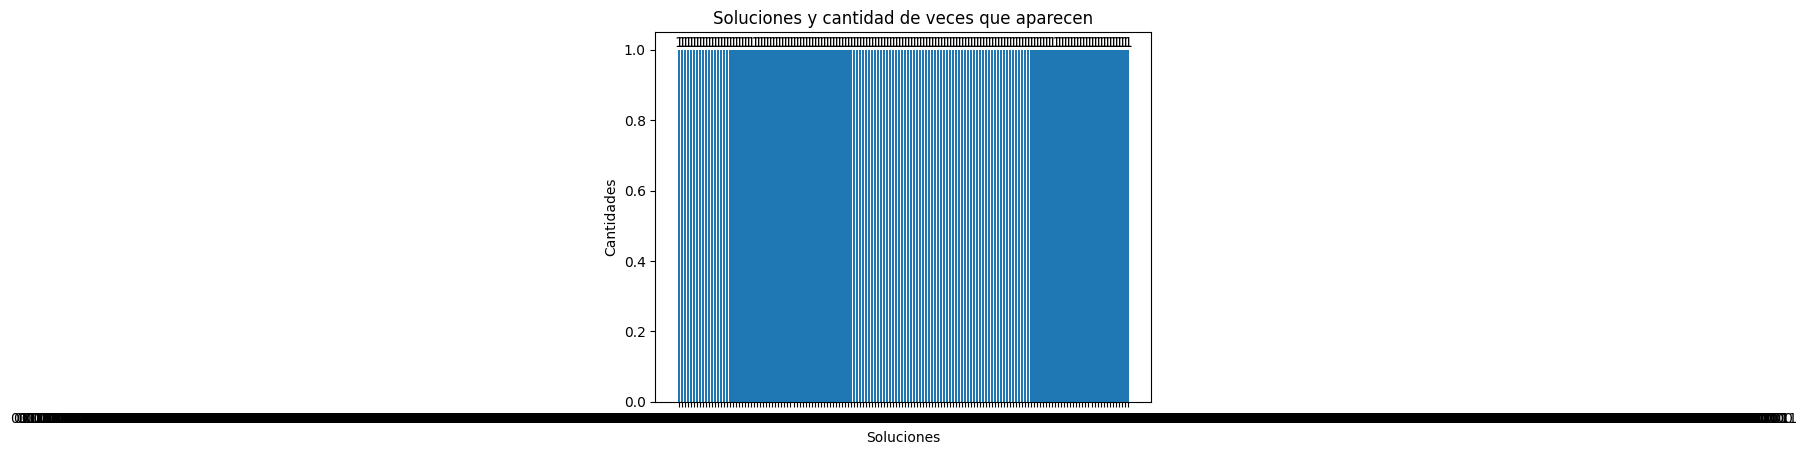

S_{JB1,LAM1,M1,1}_0 = 1
S_{JB1,LAM1,M1,1}_1 = 1
S_{JB1,LAM1,M1,1}_2 = 1
S_{JB1,LAM1,M1,1}_3 = 1
S_{JB1,LAM1,M1,2}_0 = 0
S_{JB1,LAM1,M1,2}_1 = 0
S_{JB1,LAM1,M1,2}_2 = 0
S_{JB1,LAM1,M1,2}_3 = 0
S_{JB1,LAM2,M1,1}_0 = 1
S_{JB1,LAM2,M1,1}_1 = 1
S_{JB1,LAM2,M1,1}_2 = 1
S_{JB1,LAM2,M1,1}_3 = 1
S_{JB1,LAM2,M1,2}_0 = 1
S_{JB1,LAM2,M1,2}_1 = 0
S_{JB1,LAM2,M1,2}_2 = 1
S_{JB1,LAM2,M1,2}_3 = 1
S_{JB1,B1,M2}_0 = 0
S_{JB1,B1,M2}_1 = 0
S_{JB1,B1,M2}_2 = 0
S_{JB1,B1,M2}_3 = 0
S_{JB1,B1,M3}_0 = 0
S_{JB1,B1,M3}_1 = 0
S_{JB1,B1,M3}_2 = 1
S_{JB1,B1,M3}_3 = 1
S_{JB2,LAM1,M1}_0 = 0
S_{JB2,LAM1,M1}_1 = 0
S_{JB2,LAM1,M1}_2 = 1
S_{JB2,LAM1,M1}_3 = 1
S_{JB2,B2,M2}_0 = 0
S_{JB2,B2,M2}_1 = 1
S_{JB2,B2,M2}_2 = 1
S_{JB2,B2,M2}_3 = 1
L_{JB1,LAM1,M1,1}_0 = 0
L_{JB1,LAM1,M1,1}_1 = 1
L_{JB1,LAM1,M1,1}_2 = 0
L_{JB1,LAM1,M1,1}_3 = 0
L_{JB1,LAM1,M1,2}_0 = 0
L_{JB1,LAM1,M1,2}_1 = 1
L_{JB1,LAM1,M1,2}_2 = 0
L_{JB1,LAM1,M1,2}_3 = 0
L_{JB1,LAM2,M1,1}_0 = 0
L_{JB1,LAM2,M1,1}_1 = 1
L_{JB1,LAM2,M1,1}_2 = 0
L_{JB1,LAM2,M1,1}_3 = 0


In [200]:
sampleset = sendToDwave(Q, 150)
samples_dict = count_elements(sampleset, len(Q))
make_histogram(samples_dict)

for i in x:
    print(f"{i} = {lowest_energy(sampleset)[0][x.index(i)]}")



In [201]:
print(lowest_energy(sampleset)[1])

-28.0


In [202]:
gp_model = gp.Model()
xv = np.array([[gp_model.addVar(vtype = gp.GRB.BINARY, name = f'x{i}') for i in range(len(x))]])
obj = (xv*np.matrix(Q)*np.transpose(xv))[0,0]
gp_model.params.NonConvex = -1
gp_model.setParam("TimeLimit", 120)
gp_model.setObjective(obj, gp.GRB.MINIMIZE)
gp_model.optimize()
result = np.array([var.x for var in gp_model.getVars()])


Set parameter TimeLimit to value 120
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 0 rows, 152 columns and 0 nonzeros
Model fingerprint: 0x91df42f4
Model has 450 quadratic objective terms
Variable types: 0 continuous, 152 integer (152 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e+00, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -21.0000000


Presolve removed 0 rows and 80 columns
Presolve time: 0.17s
Presolved: 384 rows, 456 columns, 1152 nonzeros
Variable types: 0 continuous, 456 integer (456 binary)

Root relaxation: objective -2.209000e+03, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -2209.0000    0   36  -21.00000 -2209.0000      -     -    0s
H    0     0                     -24.0000000 -2209.0000  9104%     -    0s
     0     0 -781.88889    0  100  -24.00000 -781.88889  3158%     -    0s
     0     0 -631.00000    0   92  -24.00000 -631.00000  2529%     -    0s
     0     0 -631.00000    0   91  -24.00000 -631.00000  2529%     -    0s
     0     2 -631.00000    0   91  -24.00000 -631.00000  2529%     -    0s
*  103    59              15     -25.0000000 -244.50000   878%  21.9    0s
H  295    58                     -26.0000000 -151.50000   483%  16.6   

In [203]:
# print(result)
print((result*np.matrix(Q)*result.reshape(-1, 1)))
# print(obj)

[[-28.]]


In [204]:
print_Q_nonZero(Q, x)

{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,LAM1,M1,1}_1 } = 4.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,LAM1,M1,1}_2 } = 8.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,LAM1,M1,1}_3 } = 16.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,B1,M2}_0 } = -1.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,B1,M2}_1 } = -2.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,B1,M2}_2 } = -4.0
{ L_{JB1,LAM1,M1,1}_0 , L_{JB1,B1,M2}_3 } = -8.0
{ L_{JB1,LAM1,M1,1}_0 , bz_{JB1,LAM1,M1,1} } = 16.0
{ L_{JB1,LAM1,M1,1}_0 , slack_2_L_{JB1,LAM1,M1,1}_0 } = -1.0
{ L_{JB1,LAM1,M1,1}_0 , slack_2_L_{JB1,LAM1,M1,1}_1 } = -2.0
{ L_{JB1,LAM1,M1,1}_0 , slack_2_L_{JB1,LAM1,M1,1}_2 } = -4.0
{ L_{JB1,LAM1,M1,1}_0 , slack_2_L_{JB1,LAM1,M1,1}_3 } = -8.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,LAM1,M1,1}_0 } = 4.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,LAM1,M1,1}_1 } = 4.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,LAM1,M1,1}_2 } = 16.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,LAM1,M1,1}_3 } = 32.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,B1,M2}_0 } = -2.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,B1,M2}_1 } = -4.0
{ L_{JB1,LAM1,M1,1}_1 , L_{JB1,B1,M2}_2 } =

  
### 4.3) Definition of d_j = ( E_j <= D_j )

(delta_j^max not considered)

    E_j - D_j >= 1 - M*d_j
    -> (E_j - D_j + M*d_j - 1 - slack)^2
  con slack <= M - 1      \\\\ con M = 16, alcanza un slack de 4 qb (slack maximo = 15)



### 4.4) Definition of ntz_m

    ntz_m = sum_jps( bz_jpms )  (((((( not necessary ))))))



<h3>4.5) Definition of X^m matrices.</h3>
Null row for each null operation

    sum_k ( X^m_(jps,k) ) = 1 - bz_jpms



<h3>4.6) Definition of u_mk</h3>

    u_mk = ( k <= o_m - ntz_m) = ( k <= o_m - sum(bz) )
    for all m and k
      k - o_m + sum(bz) >= - M * u_mk + 1
      -> (k - o_m + sum(bz) + M * u_mk - 1 - slack)^2
      with slack_max = M - 1 >= max{k - o_m + sum(bz)} = k - o_m + max{sum(bz)} = k - o_m + o_m = k

      slack_max = M - 1 >= k

      * M1: o_m = 5; k = 1,2,3,4,5;
        k = 1: slack de 1qb, M = 2
        k = 2,3: slack de 2qb, M = 4
        k = 4,5: slack de 3qb, M = 8

        (sum(bz) + 2 * u_(M1,1) - 5 - slack_0)^2
        (sum(bz) + 4 * u_(M1,2) - 4 - slack_0 - 2*slack_1)^2
        (sum(bz) + 4 * u_(M1,3) - 3 - slack_0 - 2*slack_1)^2
        (sum(bz) + 8 * u_(M1,4) - 2 - slack_0 - 2*slack_1 - 4*slack_2)^2
        (sum(bz) + 8 * u_(M1,5) - 1 - slack_0 - 2*slack_1 - 4*slack_2)^2
        
        (*) sum(bz) = bz_(JB1,LAM1,M1,1) + bz_(JB1,LAM1,M1,2) + bz_(JB1,LAM2,M1,1) + bz_(JB1,LAM2,M1,2) + bz_(JB2,LAM1,M1,1)

      * M2: o_m = 2; k = 1,2;
        k = 1: slack de 1qb, M = 2
        k = 2: slack de 2qb, M = 4

        (sum(bz) + 2 * u_mk - 2 - slack_0)^2
        (sum(bz) + 4 * u_mk - 1 - slack_0 - 2*slack_1)^2

      * M3: o_m = 1; k = 1
        u_(M3,1) = 1 - bz_(JB1,B1,M3,1)




4.6.1) X columns with only one 1 or null
  sum_jps( X^m_(jps,k) ) = u_mk



<h3>4.7) Precedence restriction</h3>

4.7.1) By precedence
  S_jp'm's' >= S_jpms + L_jpms    //for all precedences pms -> p'm's'

  S_jp'm's' = S_jpms + L_jpms + slack(4qb or less)



4.7.1.1) Final dummy operation
  E_j >= S_j(p_j)ms + L_j(p_j)ms

  E_j = S_j(p_j)ms + L_j(p_j)ms + slack(4qb or less)



4.7.2) Alternatively (+M)
  S_jp'm's' >= S_jpms + L_jpms - M * bz_jpms   //for all precedences pms -> p'm's'
  S_jp'm's' = S_jpms + L_jpms - M * bz_jpms + slack
  -> slack_max = max{ S' - S + M } = 15 + M ~ 2*M (5qb)

  S' >= S - M
  M >= max{S-S'} = 15 -> M = 15 o 16



4.7.2.1) Final dummy operation
  E_j >= S_j(p_j)ms + L_j(p_j)ms - M * bz_j(p_j)ms    for all m, s
  E_j = S_j(p_j)ms + L_j(p_j)ms - M * bz_j(p_j)ms + slack
  -> slack_max = max{ E - S + M } = 15 + M ~ 2*M (5qb)

  M >= S - E iff M >= max{S-E} = 15 -> M = 15 or 16
  
  (*) si para un E_j hay solo una restriccion (una unica tarea final), la desigualdad pasa a ser igualdad y se fija la slack como 0
            (((( fix SLACK = 0 ))))



4.7.3) A possible reinforcing constraint
  sum_k_{X^m_(jp's')k * k} + M*bz_jp'ms' >= sum_k_{X^m_(jps)k * k} - M*bz_jpms



<h3>4.8) Non-superposition of operations:</h3>
for each machine m, k = 2,...o_m

    sum_jps{
      S_jpms * X^m_(jps,k)
    }

    \>= sum_jps {
      ( S_jpms + Ljpms ) * X^m_(jps,k-1)
    }

    \+ sum_(jps, j'p's') {
      X^m_(jps,k-1) * TT^m_p,p' * X^m_(j'p's',k)
    }
    
    \- M * (1 - u_mk)




4.8.1) Avoiding the quadratic terms
  sum_jps{
    y^m_(jps,k)
  }
\>= sum_jps {
    y^m_(jps,k-1) + Ljpms * z^m_(jps,k-1)
  }
\+ sum_(jps, j'p's') {
    TT^m_p,p' w^m_(jps,j'p's',k-1)
  }
\- M * (1 - u_mk)




<h3>4.9) Quadratic constraint auxiliary variables</h3>



4.9.1) y^m_ikq = X^m_(i,k) * {S_i}_q
  P * ( 3*y^m_ikq + X^m_(i,k)*{S_i}_q - 2*{S_i}_q*y^m_ikq - 2*X^m_(i,k)*y^m_ikq )



4.9.2) z^m_ikq = X^m_(i,k) * {L_i}_q
  P * ( 3*z^m_ikq + X^m_(i,k)*{L_i}_q - 2*{L_i}_q*z^m_ikq - 2*X^m_(i,k)*z^m_ikq )



4.9.3) w^m_ijk = X^m_(i,k) * X^m_(i',k+1)
  P * ( 3*w^m_ijk + X^m_(i,k)*X^m_(j,k+1) - 2*X^m_(j,k+1)*w^m_ijk -2*X^m_(i,k)*w^m_ijk )


In [205]:
# sampleset = sendToDwave(Q, 10)
# print(sampleset)
# samples_dict = count_elements(sampleset, len(Q))
# make_histogram(samples_dict)

